## Importing

In [8]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import colorcet as cc
# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib
from utils import contain_substr

pd.set_option('use_inf_as_na', True)
pn.extension()

## Initializing Variables and Widgets

In [9]:
# Note: to add another global variable, need to init, add to global term, and define an update based on run
# TODO: download new inputdf, diagnostic, gt_freqs and change below variables to visualize.

title = '# Visualize Output'

default_tag = 'july_29_correct_weights_grid_lr1E-04alfa1E-02_lmda1E+04'
# default_tag = 'july_01_pca30_k0_parallel_grid_alfa1E+02_lmda1E+06'
default_run = '1.1.10'

epoch = '1'

# Load sample input dfs:
tags = glob(f'output/run_sem/ju*') + glob(f'output/run_sem/aug*')
tags = [t.replace('\\', '/') for t in tags]
tags = [x.split('/')[-1] for x in tags if any(i.isdigit() for i in x)]
tags = sorted(tags)
tag_select = pn.widgets.Select(name='Select Tag', options=tags, value=default_tag)
runs = glob(f'output/run_sem/{default_tag}/*_kinect_trim{default_tag}_diagnostic_*.pkl')
runs = sorted(list(set([os.path.basename(x).split('_')[0] for x in runs])))
run_select = pn.widgets.Select(name='Select Run', options=runs, value=default_run)
skel_checkbox = pn.widgets.Checkbox(name='Display Skeleton?')
obj_checkbox = pn.widgets.Checkbox(name='Display Nearest Objects?')
z_checkbox = pn.widgets.Checkbox(name='Z-score time courses?')
inverted_checkbox = pn.widgets.Checkbox(name='Show Inverted Features?', value=False)
collapse_checkbox = pn.widgets.Checkbox(name='Collapse all PEs?')
account_influence = pn.widgets.Checkbox(name='Account for # of Features on Vector?', value=True)
# Just a holder, will be updated
component_select = pn.widgets.MultiSelect(name='Select Component', options=[1], value=[1])
plot_boundaries = pn.widgets.Checkbox(name='Show Boundaries?', value=True)
activation_threshold = pn.widgets.TextInput(name='Threshold', value='0', placeholder='Enter Activation Threshold')
# Options and values for these widgets are just placeholders, will be updated based on run by listen_to_run
# frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list([0, 1, 2, 3]), value=0)
# text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')
# second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list([0, 1, 2, 3]), value=0)
# tc_feature_select = pn.widgets.MultiSelect(name='Select Time Course Features', value=['features[3]', 'features[4]'], options=['features[3]','features[4]'], size=8)
# pair_feature_select = pn.widgets.MultiSelect(name='Select 2 or 3 Features for Comparison', value=['features[3]' ,'features[4]'],options=['features[3],features[4]'], size=8)

epochs=glob(f'output/run_sem/{default_tag}/{default_run}_kinect_trim{default_tag}_diagnostic_*.pkl')
epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
epochs.sort(key=int)
epoch_select = pn.widgets.MultiSelect(name='Select Epochs', value=epochs,
    options=epochs)
second_interval = 1 # interval to group boundaries
frame_per_second = 3 # sampling rate to input to SEM
fps = 25.0 # kinect videos
frame_interval = frame_per_second * second_interval

# declare global variables that will be used for each individual runs (to save loading time)
skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, gt_freqs, \
sem_readouts, inputdf, first_frame,offset, \
        pca_input_df, pred_skel_df, skel_df_unscaled, \
        categories, pred_objhand, word2vec, objdf_z = [None] * 21

#glove_vectors = pkl.load(open('gen_sim_glove_50.pkl', 'rb'))

In [10]:
# tags = glob(f'output/run_sem/*/')
# tags = [t.replace('\\', '/') for t in tags]


## Linking Widgets and Updating Global Variables

In [11]:
'''
def second_to_frame(frame_slider, second):
    frameid = int(float(second.new) * 25)
    while frameid not in anchored_frames:
        frameid += 1
    frame_slider.value = frameid
second_slider.link(frame_slider, callbacks={'value': second_to_frame})
def text_to_secondsl(second_slider, text):
    second = int(text.new)
    second_slider.value = second
text_input.link(second_slider, callbacks={'value': text_to_secondsl})
''' 

@pn.depends(tag_select)
def update_run_options(tag_select):
    runs = glob(f'output/run_sem/{tag_select}/*_kinect_trim{tag_select}_diagnostic_*.pkl')
    runs = sorted(list(set([os.path.basename(x).split('_')[0] for x in runs])))
    print(f'Switch tag={tag_select}, update runs to: {runs}')
    print(f'old run_select value={run_select.value}')
    # changing options before changing value and let default of select change value to runs[0].
    # otherwise, if new value (runs[0]) is not in the old options, there'll be error in update_epoch_options
    print(f'changing run_select.options to: {runs}')
    run_select.options=runs
    print(f'changing run_select.value to: {runs[0]}')
    run_select.value=runs[0]
    print('Done update_run_options -- listened to tag_select.param.value')

@pn.depends(run_select, tag_select)
# def update_epoch_options(run_select):
def update_epoch_options(run_select, tag_select):
    # epochs=glob(f'output/run_sem/{tag_select.value}/{run_select}_kinect_trim{tag_select.value}_diagnostic_*.pkl')
    epochs=glob(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_diagnostic_*.pkl')
    epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
    epochs.sort(key=int)
    print(f'Switch run={run_select}, update epochs to: {epochs}')
    # likewise, these new value of epochs are not used in listen_to_run
    # because listen_to_run also listens to run_select

    print(f'old epoch(s) value={epoch_select.value}')
    # Change value before changing options because changing options both make
    # epoch_select.value to [] (default of multi_select) and trigger events
    # listening to epoch_select -- listen_to_epoch, creating error in empty list.
    print(f'changing epoch_select.value to: {epochs[0]}')
    epoch_select.value=[epochs[0]]
    print(f'changing epoch_select.options to: {epochs}')
    epoch_select.options=epochs
    print('Done update_epoch_options -- listened to run_select.param.value')

@pn.depends(run_select, tag_select, epoch_select)
def listen_to_epoch(run_select, tag_select, epoch_select):
    print(f'Switch epoch(s)={epoch_select}, update variables')
    global skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, \
        gt_freqs, sem_readouts, inputdf, first_frame, offset, \
        pca_input_df, pred_skel_df, skel_df_unscaled, \
        categories, pred_objhand, word2vec, objdf_z, epoch
    
    #epochs=glob(f'output/run_sem/{run_select.value}_kinect_trim{tag}_diagnostic_*.pkl')
    #epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
    #epochs.sort(key=int)
    epoch=epoch_select
    # These are dataframes before processing (standardizing, interpolating, concatenating, dropna, resample)
    #skel_df=pd.read_csv(f'output/skel/{run_select.value}_kinect_skel_features.csv')
    #appear_df = pd.read_csv(f'output/appear/{run_select.value}_kinect_appear.csv')
    #flow_df=pd.read_csv(f'output/vid/{run_select.value}_kinect_video_features.csv')
    # Caching frames to speed up interactive time
#     anchored_frames = pkl.load(open(f'output/run_sem/{run_select.value}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb'))
    #anchored_frames = joblib.load(f'output/run_sem_test/{run_select.value}_kinect_trimjan_27_pca_frames.joblib')
    # This data is for plotting diagnostic results
    # gt_freqs = pkl.load(open(f'output/run_sem/{tag_select.value}/{run_select.value}_kinect_trim{tag_select.value}_gtfreqs.pkl', 'rb'))
    gt_freqs = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_gtfreqs.pkl', 'rb'))
    sem_readouts = []
    inputdf = []
    for i,v in enumerate(epoch):
        # sem_readouts.append(pkl.load(open(f'output/run_sem/{tag_select.value}/{run_select.value}_kinect_trim{tag_select.value}_diagnostic_{v}.pkl', 'rb')))
        sem_readouts.append(pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_diagnostic_{v}.pkl', 'rb')))
    # Preprocess likelihoods because old_lik contains new likelihoods and repeat likelihoods as well
    #
    #     sem_readouts[i]['frame_dynamics']['old_lik'] = [[l for l in all_lik if
    #                                               not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
    #                                              for all_lik, new_lik, repeat_lik in
    #                                              zip(sem_readouts[i]['frame_dynamics']['old_lik'], sem_readouts[i]['frame_dynamics']['new_lik'], sem_readouts[i]['frame_dynamics']['repeat_lik'])]
    #     sem_readouts[i]['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts[i]['frame_dynamics']['old_lik']]
    #     sem_readouts[i]['frame_dynamics']['old_prior'] = [[p for p in all_prior if
    #                                           not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
    #                                          for all_prior, new_prior, repeat_prior in
    #                                          zip(sem_readouts[i]['frame_dynamics']['old_prior'], sem_readouts[i]['frame_dynamics']['new_prior'], sem_readouts[i]['frame_dynamics']['repeat_prior'])]
    #     sem_readouts[i]['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts[i]['frame_dynamics']['old_prior']]
    #
    # A list of dataframes after processing (appear->flow->skel->objhand). It also contains other dataframes for plotting (3 nearest_objects->object_coordinates)
    # and x_train and x_inferred of SEM.
    #     inputdf.append(pkl.load(open(f'output/run_sem/{tag_select.value}/{run_select.value}_kinect_trim{tag_select.value}_inputdf_{v}.pkl', 'rb')))
        inputdf.append(pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf_{v}.pkl', 'rb')))
    # offset to align prediction boundaries with exact video timepoint
    #LEFT
    first_frame = inputdf[0].appear_post.index[0]
    offset = first_frame / fps / second_interval

    components = inputdf[0].x_train_pca.columns.to_list()
    print(f'changing component options to {components}')
    component_select.options = components
    print(f'changing component value to {[components[0]]}')
    component_select.value = [components[0]]

    print('Done listen_to_epoch -- listened to epoch_select.param.value')
    '''
    appear_df_post = inputdf[0][0]
    flow_df_post = inputdf[0][1]
    skel_df_post = inputdf[0][2]
    objdf=inputdf[0][5]
    # TODO: uncomment to test depth
    # objdf_z = inputdf[9]
    objhand_df=inputdf[0][3]
    # Prepare dataframes to plot input skeleton and predicted skeleton
    pca_input_df = inputdf[0][6]
    pred_skel_df = inputdf[0][7]
    skel_df_unscaled = skel_df_post.copy().loc[:, skel_df_post.columns]
    pred_skel_df = pred_skel_df.loc[:, skel_df_post.columns]
    pca_input_df = pca_input_df.loc[:, skel_df_post.columns]

    skel_df_unscaled = skel_df_unscaled * skel_df.std() + skel_df.mean()
    pred_skel_df = pred_skel_df * skel_df.std() + skel_df.mean()
    pca_input_df = pca_input_df * skel_df.std() + skel_df.mean()

    skel_df_unscaled['frame'] = skel_df_unscaled.index
    pred_skel_df['frame'] = pred_skel_df.index
#     pca_input_df['frame'] = pca_input_df.index
    pca_input_df.set_index(pred_skel_df.index, inplace=True)
    pca_input_df['frame'] = pca_input_df.index # This is a workaround, will remove after new results come
    for i in range(25):
        new_column = f'J{i}_Tracked'
        skel_df_unscaled[new_column] = 'Inferred'
        pred_skel_df[new_column] = 'Predicted'
        pca_input_df[new_column] = 'Inferred'
    # Add two new distances columns to objhand_df
    # TODO: refactor so that it doesn't change the original dataframe
    i=1
    dists=[0]
    euc_dists = [0]
    while i < len(objhand_df):
        dists.append(cosine(objhand_df.iloc[i],objhand_df.iloc[i-1]))
        euc_dists.append(np.linalg.norm(objhand_df.iloc[i] - objhand_df.iloc[i-1]))
        i+=1
    objhand_df['cosine']=dists
    objhand_df['euclid'] = euc_dists
    # Prepare a dictionary of word2vec for this particular run
    categories = set()
    for c in inputdf[0][4].columns:
        categories.update(inputdf[0][4].loc[:, c])
    if None in categories:
        categories.remove(None)

    pred_objhand = inputdf[0][7]
    pred_objhand = pred_objhand.loc[:, objhand_df.drop(['euclid', 'cosine'], axis=1, errors='ignore').columns]
    word2vec = dict()
    for category in categories:
        r = np.zeros(shape=(1, pred_objhand.shape[1]))
        try:
            r += glove_vectors[category]
        except Exception as e:
            words = category.split(' ')
            for w in words:
                w = w.replace('(', '').replace(')', '')
                r += glove_vectors[w]
            r /= len(words)
        word2vec[category] = r
    
        
    # Update sliders
    #frame_slider.options = list(anchored_frames.keys())
    #frame_slider.value=list(anchored_frames.keys())[0]
    #second_slider.options=list(np.arange(inputdf[0][0].index[0] // 25, inputdf[0][0].index[-1] // 25))
    #second_slider.value=inputdf[0][0].index[0] // 25

    #features = skel_df_post.columns.tolist()
    #tc_feature_select.options = features
    #tc_feature_select.value = [features[3],features[4]]
    #pair_feature_select.options=features
    #pair_feature_select.value=[features[3],features[4]]

    #epoch_select_l.value=epochs[0]
    #epoch_select_l.options=epochs
    #epoch_select_r.value=epochs[1]
    #epoch_select_r.options=epochs
    '''


## SEM DIAGNOSTIC READOUTS

In [12]:

'''
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_likelihood(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))

    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_lik',alpha=1.00,ax=ax)

    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Likelihood '+run_select)
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Time (second)')
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_prior(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    
    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_prior',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Prior '+run_select)
    plt.close()
    return fig
'''

import matplotlib
from utils import get_binned_prediction, get_point_biserial
import scipy.stats as stats
from matplotlib.lines import Line2D

def impose_rainbow_events(ax, fig, index=None):
    cm = plt.get_cmap('gist_rainbow')
    if index is not None:
        post = sem_readouts[index]['e_hat']
        boundaries = sem_readouts[index]['boundaries']
    else:
        post = sem_readouts['e_hat']
        boundaries = sem_readouts['boundaries']
    NUM_COLORS = post.max()
    for i, (b, e) in enumerate(zip(boundaries, post)):
        if b != 0:
            second = i / frame_interval + offset
            if b == 1:
                ax.axvline(second, linestyle=(0, (5, 10)), alpha=0.3, color=cm(1. * e / NUM_COLORS), label='Old Event')
            elif b == 2:
                ax.axvline(second, linestyle='solid', alpha=0.3, color=cm(1. * e / NUM_COLORS), label='New Event')
            elif b == 3:
                ax.axvline(second, linestyle='dotted', alpha=0.3, color=cm(1. * e / NUM_COLORS), label='Restart Event')
    if index is None:
        fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cm, norm=matplotlib.colors.Normalize(vmin=0, vmax=NUM_COLORS, clip=False)),
                     orientation='horizontal')


def impose_metrics(ax, fig, index=None):
    if index:
        pred_boundaries = get_binned_prediction(sem_readouts[index]['post'], second_interval=second_interval,
                                                sample_per_second=3)
    else:

        pred_boundaries = get_binned_prediction(sem_readouts['post'], second_interval=second_interval,
                                                sample_per_second=3)
    # Padding prediction boundaries, could be changed to have higher resolution but not necessary
    pred_boundaries = np.hstack([[0] * round(first_frame / fps / second_interval), pred_boundaries]).astype(bool)
    #     gt_freqs_local = gaussian_filter1d(gt_freqs, 2)
    last = min(len(pred_boundaries), len(gt_freqs))
    bicorr = get_point_biserial(pred_boundaries[:last], gt_freqs[:last])
    pred_boundaries_gaussed = gaussian_filter1d(pred_boundaries.astype(float), 1)
    pearson_r, p = stats.pearsonr(pred_boundaries_gaussed[:last], gt_freqs[:last])
    ax.text(0.1, 0.3, f'bicorr={bicorr:.3f}, pearson={pearson_r:.3f}', fontsize=14)
    ax.set_ylim([0, 0.4])


def impose_line_boundaries(ax, fig):
    linestyles = ['dashed', 'solid', 'dotted']
    lines = [Line2D([0], [0], color='black', linewidth=1, linestyle=ls) for ls in linestyles]
    labels = ['Old Event', 'New Event', 'Restart Event']
    ax.legend(lines, labels, loc='upper right')

# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value)
def plot_diagnostic_readouts(run_select, tag_select, epoch_select, title=''):
    print('Plot Diagnostic Readouts')
    '''
    sem_readouts = []
    inputdf = []

    for i,v in enumerate(epoch_select):
        sem_readouts.append(pkl.load(open(f'output/run_sem_test/{run_select}_kinect_trim{tag}_diagnostic_{v}.pkl', 'rb')))
    # Preprocess likelihoods because old_lik contains new likelihoods and repeat likelihoods as well

        sem_readouts[i]['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts[i]['frame_dynamics']['old_lik'], sem_readouts[i]['frame_dynamics']['new_lik'], sem_readouts[i]['frame_dynamics']['repeat_lik'])]
        sem_readouts[i]['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts[i]['frame_dynamics']['old_lik']]
        sem_readouts[i]['frame_dynamics']['old_prior'] = [[p for p in all_prior if
                                              not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
                                             for all_prior, new_prior, repeat_prior in
                                             zip(sem_readouts[i]['frame_dynamics']['old_prior'], sem_readouts[i]['frame_dynamics']['new_prior'], sem_readouts[i]['frame_dynamics']['repeat_prior'])]
        sem_readouts[i]['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts[i]['frame_dynamics']['old_prior']]

    # A list of dataframes after processing (appear->flow->skel->objhand). It also contains other dataframes for plotting (3 nearest_objects->object_coordinates)
    # and x_train and x_inferred of SEM.
        inputdf.append(pkl.load(open(f'output/run_sem_test/{run_select}_kinect_trim{tag}_inputdf_{v}.pkl', 'rb')))
    '''
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(1, num_epochs, bottom=0.3)
    fig = plt.figure(figsize=(5*num_epochs,4))
    fig.suptitle(f'{tag_select} - {run_select}')
    num_colors = 0
    for i,_ in enumerate(sem_readouts):
        num_colors = max(num_colors, sem_readouts[i]['e_hat'].max())
    cmap = plt.get_cmap('gist_rainbow')
    norm = mpl.colors.Normalize(vmin=0, vmax=num_colors, clip=False)
    cbar_ax = fig.add_axes([.125, .1, .775, .03])
    cbar = mpl.colorbar.ColorbarBase(ax=cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
    cbar.set_label('Events')
    # fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), orientation='horizontal')
    for i,_ in enumerate(sem_readouts):
        # fig, ax = plt.subplots()
        ax = fig.add_subplot(gs[i])
        ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
        ax.set_xlabel('Time (second)')
        ax.set_ylabel('Boundary Probability')
        ax.set_title('Boundary Type ' + run_select + f' Epoch {epoch_select[i]}')

        # impose_rainbow_events(ax, fig)
        # impose_line_boundaries(ax, fig)
        # impose_metrics(ax, fig)
        boundaries = sem_readouts[i]['boundaries']
        e_hat = sem_readouts[i]['e_hat']
        for i, (b, e) in enumerate(zip(boundaries, e_hat)):
            if b != 0:
                second = i / frame_interval + offset
                if b == 1:  # Switch to an old event
                    ax.axvline(second, linestyle=(0, (5, 10)), alpha=0.3, color=cmap(1. * e / num_colors), label='Old Event')
                elif b == 2:  # Create a new event
                    ax.axvline(second, linestyle='solid', alpha=0.3, color=cmap(1. * e / num_colors), label='New Event')
                elif b == 3:  # Restart the current event
                    ax.axvline(second, linestyle='dotted', alpha=0.3, color=cmap(1. * e / num_colors), label='Restart Event')
        from matplotlib.lines import Line2D
        linestyles = ['dashed', 'solid', 'dotted']
        lines = [Line2D([0], [0], color='black', linewidth=1, linestyle=ls) for ls in linestyles]
        labels = ['Old Event', 'New Event', 'Restart Event']
        ax.legend(lines, labels, loc='upper right')
        # ax.set_ylim([0, 1.0])
    # fig.tight_layout()
    plt.close()
    return fig

# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value)
def plot_pe(run_select, tag_select, epoch_select):
    print('Plot Prediction Error')
    fig,ax = plt.subplots()
    fig.suptitle(f'{tag_select} - {run_select}')
    df = pd.DataFrame(columns=['pe','second','epoch'])
    for i,v in enumerate(sem_readouts):
        df1 = pd.DataFrame({'pe':v['pe'], 'second':inputdf[0].appear_post.index / 25,'epoch':epoch_select[i]},index=inputdf[0].appear_post.index)
        #df1['second'] = df.index / 25
        df=df.append(df1)
    df.epoch = pd.to_numeric(df.epoch, errors='coerce')
    for key,grp in df.groupby(['epoch']):
        grp.plot(kind='line', x='second', y='pe',label=key,alpha=0.5,ax=ax)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        #ax.set_ylim([-3, 3])
        #ax.legend()
    ax.set_title('Prediction Error '+run_select)

    # impose_rainbow_events(ax, fig)
    # impose_line_boundaries(ax, fig)
    # impose_metrics(ax, fig)

    plt.close()
    return fig

'''
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_surprise(frame_slider, run_select):

    fig, ax = plt.subplots()
    df = pd.DataFrame({'surprise':sem_readouts['surprise']}, index=inputdf[0].index)
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='surprise',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Bayesian Surprise '+run_select)
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    ax.get_legend().remove()
    plt.close()
    return fig
'''
# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value)
def plot_posterior(run_select, tag_select, epoch_select):
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(1, num_epochs)
    fig = plt.figure(figsize=(5*num_epochs,4))
    fig.suptitle(f'{tag_select} - {run_select}')
    for i,v in enumerate(sem_readouts):
        ax = fig.add_subplot(gs[i])
        df = pd.DataFrame(v['post'], index=inputdf[i].appear_post.index)
    #     df =df.loc[:, (df != 0).any(axis=0)]
        df =df.loc[:, (df > 1e-2).any(axis=0)]
        df.index = df.index / 25
        df.index.names = ['second']
        NUM_COLORS = len(df.columns)
        cm = plt.get_cmap('gist_rainbow')
        ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        df.plot.area(ax=ax, stacked=False, ylim=(0,1))
        #plt.ylim(0.0,1.0)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        ax.set_title('Posterior Probability '+run_select+' Epoch '+epoch_select[i])
        ax.get_legend().remove()
    plt.close()
    return fig

def plot_active_models_and_annotations(run_select, tag_select, epoch_select):
    print('Plot Active Models and Annotations')
    # Load SEM active events (e_hat)
    edf = pd.DataFrame()
    for i,v in enumerate(sem_readouts):
        edf[epoch_select[i]] = v['e_hat']
    # add empty column for annotations:
    edf['Annot'] = np.nan
    tedf = edf.T
    # Convert from SEM frames (3 Hz) to seconds:
    tedf.columns = [str(int(x/3)) for x in tedf.columns]
    tedf.index.name = 'Epoch'
    fig = plt.figure(figsize = (18, 8))
    fig.suptitle(f'{tag_select} - {run_select}')

    df = pd.read_csv('./event_annotation_timing.csv')
    rundf = df[df['run'] == run_select] # select annotated events for selected run
    # Create SEM events color bar
    n = len(rundf)
    semmax = int(tedf.max().max())
    semmin = int(tedf.min().min())
    cmap1 = ListedColormap(cc.glasbey_dark[semmin:semmax+1])
    norm = mpl.colors.Normalize(vmin=semmin, vmax=semmax+1, clip=False)
    cbar1_ax = fig.add_axes([.7, .1, .05, .8])
    cbar1 = mpl.colorbar.ColorbarBase(ax=cbar1_ax, cmap=cmap1, norm=norm)
    r1 = cbar1.vmax - cbar1.vmin
    cbar1.set_ticks([((cbar1.vmin + r1) / (semmax+1)) * (0.5 + i) for i in range(semmin,semmax+1)])
    cbar1.set_ticklabels(range(semmin,semmax+1))
    cbar1.set_label('SEM Events')

    # Plot active events heatmap:
    heat_ax = fig.add_axes([.1, .1, .55, .8])
    sns.heatmap(tedf,cmap=cmap1,ax=heat_ax, cbar=False)
    heat_ax.set(xlabel = 'Time (s)')

    # Add rectangles for annotated events:
    clist = []
    for i in range(len(rundf)):
        row = rundf.iloc[i]
        ymin = len(epoch_select)
        on = row['startsec']
        off = row['endsec']
        name = row['evname']
        # convert from seconds to SEM frames:
        on = 3*on
        off = 3*off
        xmin = edf.index.get_loc(edf[edf.index < on].iloc[-1].name)
        try:
            width = edf.index.get_loc(edf[edf.index < off].iloc[-1].name)-xmin
        except:
            width = edf.index.max()
        heat_ax.add_patch(Rectangle((xmin, ymin), width, 1, fill=False, edgecolor= cc.glasbey_dark[i+semmax+1],lw=3, hatch ='/'))

        clist.append(name)
    #fig.colorbar(s)
    # Add colorbar for annotated events
    cmap2 = ListedColormap(cc.glasbey_dark[0+semmax+1:n+semmax+1])
    norm2 = mpl.colors.Normalize(vmin=0.0, vmax=n, clip=False)
    cbar2_ax = fig.add_axes([.8, .1, .05, .8])
    cbar2 = mpl.colorbar.ColorbarBase(ax=cbar2_ax, cmap=cmap2, norm=norm2)
    #cbar2 = mpl.colorbar.ColorbarPatch(cbar2_ax,s, cmap=cmap2, norm=norm2, hatch = '.')
    #cbar2.set_ticks([.5,1.5,2.5,3.5,4.5,5.5,6.5])
    r2 = cbar2.vmax - cbar2.vmin
    cbar2.set_ticks([((cbar2.vmin + r2) / (n)) * (0.5 + i) for i in range(n)])
    #cbar2.set_ticklabels([1,2,3,4,5,6,7])
    cbar2.set_ticklabels(clist)
    cbar2.set_label('Annotated Events')

    plt.close()
    return fig

# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value)
def plot_post_prior_lik(run_select, tag_select, epoch_select):
    print('Plot Posterior, Prior, Likelihood')
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(3, num_epochs)
    fig = plt.figure(figsize=(5*num_epochs,12))
    fig.suptitle(f'{tag_select} - {run_select}')
    for i,v in enumerate(sem_readouts):
        ax1 = fig.add_subplot(gs[0,i])
        df_post = pd.DataFrame(v['post'])
        df_filtered_post = df_post.loc[:, (df_post > 1e-2).any(axis=0)]
        # print('done filter post')
        # This function take a lot of time to plot, especially with many event models
        sns.lineplot(data=df_filtered_post, ax=ax1)
        # print('done plotting post')
        ax1.set_title('Posterior (normalized) Epoch '+epoch_select[i])
        '''
        #     df =df.loc[:, (df != 0).any(axis=0)]
        df =df.loc[:, (df > 1e-2).any(axis=0)]
        df.index = df.index / 25
        df.index.names = ['second']
        NUM_COLORS = len(df.columns)
        cm = plt.get_cmap('gist_rainbow')
        ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        df.plot.area(ax=ax, stacked=False, ylim=(0,1))
        #plt.ylim(0.0,1.0)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        ax.set_title('Posterior Probability '+run_select+' Epoch '+epoch_select[i])
        ax.get_legend().remove()
        '''
        '''
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex='all')
        df_post = pd.DataFrame(sem_readouts['post'])
        df_filtered_post = df_post.loc[:, (df_post != 0).any(axis=0)]
        sns.lineplot(data=df_filtered_post, ax=ax1)
        ax1.set_title('Posterior (normalized)')
        # cbar_ax = fig.add_axes([.91, .3, .03, .4])
        # fig.tight_layout()
        # cbar_ax = fig.add_axes([.125, .0, .775, .03])
        '''
        df_lik = pd.DataFrame(v['log_like'], index=inputdf[i].appear_post.index)
        df_filtered_lik = df_lik.dropna(axis=1, how='all')
        # print('done filter likelihood')
        df_prior = pd.DataFrame(v['log_prior'], index=inputdf[i].appear_post.index)
        df_filtered_prior = df_prior.dropna(axis=1, how='all')
        # print('done filter prior')
        max_color = min(max(df_filtered_lik.max().max(), df_filtered_prior.max().max()), 4)
        min_color = max(min(df_filtered_lik.min().min(), df_filtered_prior.min().min()), -4)

        ax2 = fig.add_subplot(gs[1,i],sharex=ax1)
        sns.heatmap(df_filtered_lik.T, ax=ax2,
                    cbar_kws={"orientation": "horizontal"},
                    vmin=min_color, vmax=max_color,
                    # cbar_ax=cbar_ax,
                    )
        # print('done plotting likelihood')
        ax2.set_title('Log-Likelihood (absolute) Epoch '+epoch_select[i])

        ax3 = fig.add_subplot(gs[2,i], sharex=ax1)
        sns.heatmap(df_filtered_prior.T, ax=ax3,
                    cbar_kws={"orientation": "horizontal"},
                    vmin=min_color, vmax=max_color,
                    # cbar_ax=cbar_ax,
                    )
        # print('done plotting prior')
        ax3.set_title('Log-Prior (absolute) Epoch '+epoch_select[i])
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
    plt.close()
    return fig
    #plt.savefig('Probabilities')

# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value, inverted_checkbox.param.value)
def plot_heatmap_prediction(run_select, tag_select, epoch_select, inverted_checkbox=False, min_heat=-4, max_heat=4, fig=None, axes=None, cbar_ax=None):
    print('Plot Heatmap Prediction')
    if fig is None:
        fig, axes = plt.subplots(nrows=2, ncols=len(inputdf), figsize=(4*len(inputdf), 8), sharex=True)
        fig.suptitle(f'{tag_select} - {run_select}', fontsize=16)
        axes = axes.reshape((2, len(inputdf)))
        cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i,_ in enumerate(inputdf):

        # inputdf = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf{epoch}.pkl', 'rb'))

        appear_df_post = inputdf[i].appear_post
        optical_df_post = inputdf[i].optical_post
        skel_df_post = inputdf[i].skel_post
        objhand_df_post = inputdf[i].objhand_post

        input_pca = inputdf[i].x_train_pca
        pred_pca = inputdf[i].x_inferred_pca
        if inverted_checkbox:
            input_inverted = inputdf[i].x_train_inverted
            pred_inverted = inputdf[i].x_inferred_inverted
            # to remove 3D and 2D columns if necessary
            remove = ['3D', '2D']
            for c in input_inverted.columns:
                if contain_substr(c, keeps=remove):
                    pred_inverted.drop([c], axis=1, inplace=True)
                    input_inverted.drop([c], axis=1, inplace=True)
            input = input_inverted
            pred = pred_inverted
        else:
            input = input_pca
            pred = pred_pca

        for index, ax in enumerate(axes[:, i].flat):
            sns.heatmap(pred.T if index else input.T, ax=ax,
                        cbar=index == 0,
                        vmin=min_heat, vmax=max_heat,
                        cbar_ax=None if index else cbar_ax)
            ax.set_title((f'Prediction Epoch {epoch_select[i]}' if index else f'Input - {run_select}'))

#     fig.savefig(f'{run_select}_{tag_select}_heatmap.png')
    plt.close(fig)
    return fig

def frame_to_second(pd_series: pd.Series):
    pd_series.index = pd_series.index / 25
    pd_series.rename_axis('second', inplace=True)
    return pd_series
# @pn.depends(run_select.param.value, tag_select.param.value, epoch_select.param.value, collapse_checkbox.param.value, account_influence.param.value)
def characterize_pe(run_select, tag_select, epoch_select, collapse_checkbox=False, account_influence=False, fig=None, axes=None):
    print('Plot Characterized Prediction Errors')
    if fig is None:
        fig, axes = plt.subplots(nrows=1, ncols=len(inputdf), figsize=(4 * len(inputdf), 4), squeeze=False)
        fig.suptitle(f'{tag_select} - {run_select}')
        axes = axes.reshape((1, len(inputdf)))
    for i, _ in enumerate(inputdf):
        # inputdf = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf[i]{epoch}.pkl', 'rb'))

        appear_df_post = inputdf[i].appear_post
        optical_df_post = inputdf[i].optical_post
        skel_df_post = inputdf[i].skel_post
        objhand_df_post = inputdf[i].objhand_post
        if 'scene_motion' in tag_select:
            objspeed_df_post = inputdf[i].objspeed_post

        # Prepare dataframes to plot input skeleton and predicted skeleton
        pred_appear_df = inputdf[i].x_inferred_inverted.loc[:, appear_df_post.columns]
        pred_optical_df = inputdf[i].x_inferred_inverted.loc[:, optical_df_post.columns]
        pred_skel_df = inputdf[i].x_inferred_inverted.loc[:, skel_df_post.columns]
        pred_objhand_df = inputdf[i].x_inferred_inverted.loc[:, objhand_df_post.columns]
        if 'scene_motion' in tag_select:
            pred_objspeed_df = inputdf[i].x_inferred_inverted.loc[:, objspeed_df_post.columns]

        pca_appear_df = inputdf[i].x_train_inverted.loc[:, appear_df_post.columns]
        pca_optical_df = inputdf[i].x_train_inverted.loc[:, optical_df_post.columns]
        pca_skel_df = inputdf[i].x_train_inverted.loc[:, skel_df_post.columns]
        pca_objhand_df = inputdf[i].x_train_inverted.loc[:, objhand_df_post.columns]
        if 'scene_motion' in tag_select:
            pca_objspeed_df = inputdf[i].x_train_inverted.loc[:, objspeed_df_post.columns]

        # to remove 3D and 2D columns if necessary
        keep = ['acceleration', 'speed', 'dist_from_J1', 'interhand']
        for c in pred_skel_df.columns:
            if contain_substr(c, keeps=keep):
                continue
            else:
                pred_skel_df.drop([c], axis=1, inplace=True)
                pca_skel_df.drop([c], axis=1, inplace=True)
        pe_appear = (pred_appear_df - pca_appear_df)
        pe_optical = (pred_optical_df - pca_optical_df)
        pe_skel = (pred_skel_df - pca_skel_df)
        pe_objhand = (pred_objhand_df - pca_objhand_df)
        if 'scene_motion' in tag_select:
            pe_objspeed = (pred_objspeed_df - pca_objspeed_df)

        if account_influence:
            pe_appear = np.sqrt(np.square(pe_appear).sum(axis=1))
            pe_optical = np.sqrt(np.square(pe_optical).sum(axis=1))
            pe_skel = np.sqrt(np.square(pe_skel).sum(axis=1))
            pe_objhand = np.sqrt(np.square(pe_objhand).sum(axis=1))
            if 'scene_motion' in tag_select:
                pe_objspeed = np.sqrt(np.square(pe_objspeed).sum(axis=1))
        else:
            pe_appear = np.sqrt(np.square(pe_appear).mean(axis=1))
            pe_optical = np.sqrt(np.square(pe_optical).mean(axis=1))
            pe_skel = np.sqrt(np.square(pe_skel).mean(axis=1))
            pe_objhand = np.sqrt(np.square(pe_objhand).mean(axis=1))
            if 'scene_motion' in tag_select:
                pe_objspeed = np.sqrt(np.square(pe_objspeed).mean(axis=1))


        pe_appear = frame_to_second(pe_appear)
        pe_optical = frame_to_second(pe_optical)
        pe_skel = frame_to_second(pe_skel)
        pe_objhand = frame_to_second(pe_objhand)
        if 'scene_motion' in tag_select:
            pe_objspeed = frame_to_second(pe_objspeed)
        if collapse_checkbox:
            data_frames = [pe_appear, pe_optical, pe_skel, pe_objhand]
            if 'scene_motion' in tag_select:
                data_frames.append(pe_objspeed)
            pe_combined = pd.concat(data_frames, axis=1).mean(axis=1)
            pe_combined.plot(ax=axes[0, i], label='Combined PE')
        else:
            pe_appear.plot(ax=axes[0, i], sharey=True, alpha=0.7, label='Appear')
            pe_optical.plot(ax=axes[0, i], sharey=True, alpha=0.7, label='Optical')
            pe_skel.plot(ax=axes[0, i], sharey=True, alpha=0.7, label='Skel')
            pe_objhand.plot(ax=axes[0, i], sharey=True, alpha=0.7, label='Objhand')
            if 'scene_motion' in tag_select:
               pe_objspeed.plot(ax=axes[0, i], sharey=True, alpha=0.7, label='Objspeed')
        axes[0, i].legend()
        axes[0, i].set_ylabel('Averaged Prediction Error')
        axes[0, i].set_title(f'{run_select}_{tag_select}_{epoch_select[i]}.png')
    plt.close(fig)
    return fig

def plot_line_prediction(run_select, tag_select, epoch_select, component, inverted_checkbox=False, plot_boundaries=True, fig=None, axes=None):
    print('Plot Line Prediction')
    if fig is None:
        fig, axes = plt.subplots(nrows=len(component), ncols=len(inputdf), figsize=(4*len(inputdf), 4*len(component)), sharex=True, squeeze=False)
        fig.suptitle(f'{tag_select} - {run_select}', fontsize=14)
        axes = axes.reshape((len(component), len(inputdf)))

    for i, e in enumerate(epoch_select):
        input_pca = inputdf[i].x_train_pca
        pred_pca = inputdf[i].x_inferred_pca
        if inverted_checkbox:
            input_inverted = inputdf[i].x_train_inverted
            pred_inverted = inputdf[i].x_inferred_inverted
            # to remove 3D and 2D columns if necessary
            remove = ['3D', '2D']
            for c in input_inverted.columns:
                if contain_substr(c, keeps=remove):
                    pred_inverted.drop([c], axis=1, inplace=True)
                    input_inverted.drop([c], axis=1, inplace=True)
            inp = input_inverted
            pred = pred_inverted
        else:
            inp = input_pca
            pred = pred_pca
        pred = pred.rename(lambda x: str(x)+'_pred', axis=1)
        inp = inp.rename(lambda x: str(x) + '_inp', axis=1)

        for j, pc in enumerate(component):
            data = pd.concat([pred.iloc[:, pc], inp.iloc[:, pc]], axis=1)
            data.index = data.index / 25
            data.index.rename('second', inplace=True)
            sns.lineplot(data=data, ax=axes[j, i])
            axes[j, i].set_title(f'{pc}-th Component - Epoch {e}')

            if plot_boundaries:
                impose_rainbow_events(ax=axes[j, i], fig=fig, index=i)
            # impose_line_boundaries(axes[j, i], fig)

    plt.close(fig)
    return fig

def plot_activations_hist(run_select, tag_select, epoch_select, threshold=0, fig=None, axes=None):
    print('Plot Histogram of Activations')
    if fig is None:
        fig, axes = plt.subplots(nrows=1, ncols=len(inputdf), figsize=(4*len(inputdf), 4), squeeze=False, sharex=True, sharey=True)
        fig.suptitle(f'{tag_select} - {run_select}', fontsize=14)
        axes = axes.reshape((1, len(inputdf)))
    for i, sem_readout in enumerate(sem_readouts):
        events = pd.DataFrame(sem_readout['c'][sem_readout['c'] > int(threshold)], columns=['activations'])
        axes[0, i].hist(x=events.index, weights=events['activations'], bins=len(events))
        axes[0, i].set_title('Activations Histogram Epoch ' + epoch_select[i])

    plt.close(fig)
    return fig

In [13]:
import param
class ActionExample(param.Parameterized):


    action = param.Action(lambda x: x.param.trigger('action'), label='Update All Plots!')

    action_diagnostic = param.Action(lambda x: x.param.trigger('action_diagnostic'), label='Update Diagnostic Readouts')
    @param.depends('action_diagnostic', 'action')
    # @param.depends('action')
    def plot_diagnostic_readouts(self):
        return plot_diagnostic_readouts(run_select.value, tag_select.value, epoch_select.value)
    
    action_pe = param.Action(lambda x: x.param.trigger('action_pe'), label='Update Prediction Errors')
    @param.depends('action_pe', 'action')
    # @param.depends('action')
    def plot_pe(self):
        return plot_pe(run_select.value, tag_select.value, epoch_select.value)
    
    action_active_models_and_annotations = param.Action(lambda x: x.param.trigger('action_active_models_and_annotations'),
                                                        label='Update Active Models')
    @param.depends('action_active_models_and_annotations', 'action')
    def plot_active_models_and_annotations(self):
        return plot_active_models_and_annotations(run_select.value, tag_select.value, epoch_select.value)

    action_probability = param.Action(lambda x: x.param.trigger('action_probability'), label='Update Probabilities')
    @param.depends('action_probability', 'action')
    # @param.depends('action')
    def plot_post_prior_lik(self):
        return plot_post_prior_lik(run_select.value, tag_select.value, epoch_select.value)
    
    action_heatmap = param.Action(lambda x: x.param.trigger('action_heatmap'), label='Update Heatmap Prediction')
    @param.depends('action_heatmap', 'action')
    # @param.depends('action')
    def plot_heatmap_prediction(self):
        return plot_heatmap_prediction(run_select.value, tag_select.value, epoch_select.value)
    
    action_characterize_pe = param.Action(lambda x: x.param.trigger('action_characterize_pe'), label='Update Characterized PE')
    @param.depends('action_characterize_pe', 'action')
    # @param.depends('action')
    def characterize_pe(self):
        return characterize_pe(run_select.value, tag_select.value, epoch_select.value,
                               collapse_checkbox.value, account_influence.value)
    
    action_line = param.Action(lambda x: x.param.trigger('action_line'), label='Update Line Prediction')
    @param.depends('action_line', 'action')
    # @param.depends('action')
    def plot_line_prediction(self):
        if isinstance(component_select.value, int):
            component_select.value = [component_select.value]
        return plot_line_prediction(run_select.value, tag_select.value, epoch_select.value,
                                    component_select.value, inverted_checkbox.value, plot_boundaries.value)

    action_activation_hist = param.Action(lambda x: x.param.trigger('action_activation_hist'), label='Update Activation Hist')
    @param.depends('action_activation_hist', 'action')
    # @param.depends('action')
    def plot_activations_hist(self):
        return plot_activations_hist(run_select.value, tag_select.value, epoch_select.value,
                                     threshold=int(activation_threshold.value))

action_example = ActionExample()

Switch tag=july_01_pca30_k0_parallel_grid_alfa1E+02_lmda1E+06, update runs to: ['1.1.10']
old run_select value=1.1.10
changing run_select.options to: ['1.1.10']
changing run_select.value to: 1.1.10
Done update_run_options -- listened to tag_select.param.value
Switch run=1.1.10, update epochs to: ['1']
old epoch(s) value=['1']
changing epoch_select.value to: 1
changing epoch_select.options to: ['1']
Done update_epoch_options -- listened to run_select.param.value
Switch epoch(s)=['1'], update variables
changing component options to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
changing component value to [0]
Done listen_to_epoch -- listened to epoch_select.param.value
Plot Diagnostic Readouts
Plot Posterior, Prior, Likelihood
Plot Active Models
Plot Prediction Error
Plot Heatmap Prediction
Plot Line Prediction
Plot Characterized Prediction Errors
Plot Histogram of Activations


Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] ParamFunction(function)
        [1] Select(options=['july_01_pca30_k0_paralle...], value='july_01_pca30_k0_parallel...)
    [2] Row
        [0] ParamFunction(function)
        [1] Select(options=['1.1.10'], value='1.1.10')
    [3] Row
        [0] ParamFunction(function)
        [1] MultiSelect(name='Select Epochs', options=['1'], value=['1'])
    [4] Button(name='Update All Plots!')
    [5] Row
        [0] Tabs(dynamic=True, tabs_location='left')
            [0] Column
                [0] Button(name='Update Diagnostic R...)
                [1] ParamMethod(method)
            [1] Column
                [0] Button(name='Update Probabilities')
                [1] ParamMethod(method)
            [2] Column
                [0] Button(name='Update Active Models')
                [1] ParamMethod(method)
            [3] Column
                [0] Button(name='Update Prediction E...)
                [1] ParamMethod(method)
            [4] Column
                [0] Button(name='Update Heatmap P...)
                [1] ParamMethod(method)
            [5] Column
                [0] Button(name='Update Line Prediction')
                [1] MultiSelect(name='Select Component', options=[0, 1, 2, 3, 4, ...], value=[0])
                [2] Checkbox(name='Show Boundaries?', value=True)
                [3] ParamMethod(method)
            [6] Column
                [0] Button(name='Update Characterized PE')
                [1] Checkbox(name='Account for #..., value=True)
                [2] Checkbox(name='Collapse all PEs?')
                [3] ParamMethod(method)
            [7] Column
                [0] Button(name='Update Activation Hist')
                [1] TextInput(name='Threshold', placeholder='Enter Activation T..., value='0')
                [2] ParamMethod(method)
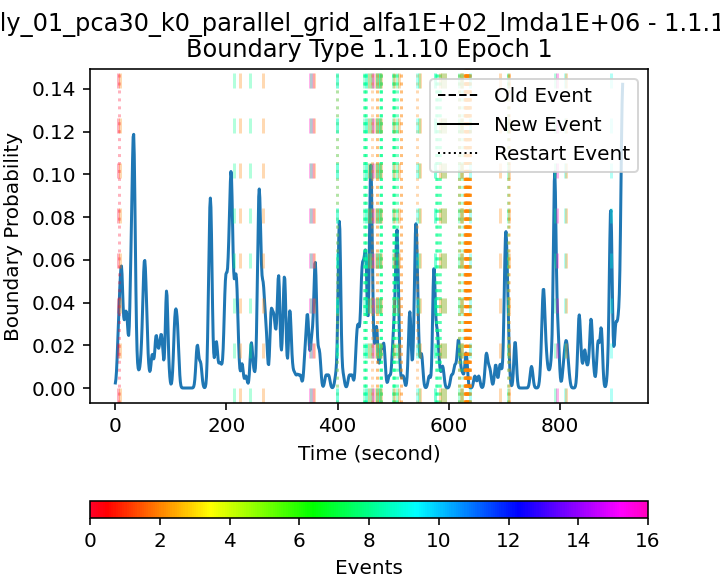

In [14]:
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(update_run_options, tag_select),
    pn.Row(update_epoch_options, run_select),
    pn.Row(listen_to_epoch, epoch_select),
    pn.panel(action_example.param.action),
    pn.Row(pn.Tabs(('diagnostic readouts', pn.Column(action_example.param.action_diagnostic, action_example.plot_diagnostic_readouts)),
            ('posterior prior likelihood',pn.Column(action_example.param.action_probability, action_example.plot_post_prior_lik)),
            ('active models',pn.Column(action_example.param.action_active_models_and_annotations, action_example.plot_active_models_and_annotations)),
            ('prediction error',pn.Column(action_example.param.action_pe, action_example.plot_pe)),
            ('prediction heatmap', pn.Column(action_example.param.action_heatmap, action_example.plot_heatmap_prediction)),
            ('prediction line', pn.Column(action_example.param.action_line, component_select, plot_boundaries, action_example.plot_line_prediction)),
            ('characterize PE', pn.Column(action_example.param.action_characterize_pe, account_influence, collapse_checkbox, action_example.characterize_pe)),
            ('activations histogram', pn.Column(action_example.param.action_activation_hist, activation_threshold, action_example.plot_activations_hist)),
                   tabs_location='left',
                   dynamic=True))
)

# Launch the dashboard
dashboard.servable()

In [15]:
# pkl.load(open(f'output/run_sem/{tag_select.value}/{run_select.value}_kinect_trim{tag_select.value}_gtfreqs.pkl', 'rb'))


In [16]:
# f'output/run_sem/{tag_select.value}/{run_select.value}_kinect_trim{tag_select.value}_gtfreqs.pkl'
# 'output/run_sem/june_29_pca30_k0_parallel_grid_alfa1E-02_lmda1E+04/1.1.10_kinect_trimjune_29_pca30_k0_parallel_grid_alfa1E-02_lmda1E+04_gtfreqs.pkl'
# pkl.load(open(f'output/run_sem/june_29_pca30_k0_parallel_grid_alfa1E-02_lmda1E+04/1.1.10_kinect_trimjune_29_pca30_k0_parallel_grid_alfa1E-02_lmda1E+04_gtfreqs.pkl', 'rb'))

## Dashboard Arrangement

In [12]:
#dashboard = pn.Column(
#    pn.Row(title),
#    pn.Row(run_select,listen_to_run,update_epoch_options),
#    pn.Row(pn.Column(frame_slider, second_slider,text_input), pn.Column(skel_checkbox,obj_checkbox,z_checkbox)),
#    pn.Row(epoch_select),
#    pn.Row(plot_posterior),
#    pn.Row(plot_pe)
#)

# Launch the dashboard
#dashboard.servable()

In [13]:
'''
# Non-tabbed Version
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(tag_select,run_select,listen_to_run,update_run_options,update_epoch_options),
    pn.Row(epoch_select),
    pn.Row(plot_diagnostic_readouts),
    #pn.Row(plot_pe),
    pn.Row(plot_post_prior_lik),
    pn.Row(plot_active_models),
)

# Launch the dashboard
dashboard.servable()
'''

'\n# Non-tabbed Version\ndashboard = pn.Column(\n    pn.Row(title),\n    pn.Row(tag_select,run_select,listen_to_run,update_run_options,update_epoch_options),\n    pn.Row(epoch_select),\n    pn.Row(plot_diagnostic_readouts),\n    #pn.Row(plot_pe),\n    pn.Row(plot_post_prior_lik),\n    pn.Row(plot_active_models),\n)\n\n# Launch the dashboard\ndashboard.servable()\n'

In [ ]:
# Tabbed Version
# dashboard = pn.Column(
#     pn.Row(title),
#     pn.Row(update_run_options, tag_select),
#     pn.Row(update_epoch_options, run_select),
#     pn.Row(listen_to_epoch, epoch_select),
#     pn.Row(pn.Tabs(('diagnostic readouts',plot_diagnostic_readouts),
#             ('posterior prior likelihood',plot_post_prior_lik),
#             ('active models',plot_active_models),
#             ('prediction error',plot_pe),
#             ('prediction heatmap', plot_heatmap_prediction),
#             ('characterize PE', pn.Column(account_influence, collapse_checkbox, characterize_pe)),
#                    tabs_location='left',
#                    dynamic=True))
# )
#
# # Launch the dashboard
# dashboard.servable()

Switch tag=may_22_df60_nh5_grid_alfa1E+02_lmda5E+01, update runs to: ['1.1.10', '2.2.10', '3.3.10']
old run_select value=1.1.10
changing run_select.options to: ['1.1.10', '2.2.10', '3.3.10']
changing run_select.value to: 1.1.10
Done update_run_options -- listened to tag_select.param.value
Switch run=1.1.10, update epochs to: ['1', '10', '20']
old epoch(s) value=['1', '10', '20']
changing epoch_select.value to: ['1', '10', '20']
changing epoch_select.options to: ['1', '10', '20']
Done update_epoch_options -- listened to run_select.param.value
Switch epoch(s)=['1', '10', '20'], update variables
Done listen_to_epoch -- listened to epoch_select.param.value


## Appear Features

In [ ]:
'''
@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Appearances and Disappearances '+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot_post(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df_post.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances Post'+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig
    '''

## Skeleton Features

In [ ]:
'''
@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in tc_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
            #df[feat]=df[feat].apply(zscore)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    for feat in tc_feature_select:
        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Feature Time Course '+run_select)
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def pair_plot(pair_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in pair_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
    pdf = df[df['frame'] == frame_slider]

    if len(pair_feature_select) == 2:
        fig,ax = plt.subplots()
        df.plot(kind='scatter', x=pair_feature_select[0], y=pair_feature_select[1],alpha=0.5,c=df['frame'],colormap='viridis',ax=ax)
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],marker='o',markersize=15,color='r',alpha=0.5)
    elif len(pair_feature_select) == 3:
        fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
        p=ax.scatter(df[pair_feature_select[0]],df[pair_feature_select[1]],df[pair_feature_select[2]],c=df['frame'],cmap='viridis')
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],pdf[pair_feature_select[2]],marker='o',markersize=15,color='r')
        ax.set_xlabel(pair_feature_select[0])
        ax.set_ylabel(pair_feature_select[1])
        ax.set_zlabel(pair_feature_select[2])

        fig.colorbar(p)
    else:
        fig,ax = plt.subplots()
    plt.title('Compare Features '+run_select)
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_reduced_features(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=2, whiten=True)
    x_train = pca.fit_transform(x_train)
    df = pd.DataFrame(x_train, index=skel_df_post.index, columns=['pc_1', 'pc_2'])
    fig, ax = plt.subplots()
    df.plot(kind='scatter', x=df.columns[0], y=df.columns[1],alpha=0.5,c=df.index,colormap='viridis',ax=ax)
    ax.plot(df.loc[frame_slider, 'pc_1'], df.loc[frame_slider, 'pc_2'], marker='o',markersize=15,color='r',alpha=0.5)
    ax.set_title('Principal Components for Skeletons')
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(cosine(x_train[i], x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Cosine Disntance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post_euclid(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Euclidean Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close()
    return fig
    '''

## Object-Hand Features

In [ ]:
'''

@pn.depends(frame_slider.param.value,run_select.param.value)
def objhand_plot(frame_slider,run_select): # start function
    x_train = objhand_df.drop(['cosine', 'euclid'], errors='ignore').to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=objhand_df.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Objhand PCA Euclid Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')


    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig
    '''

## Video Features

In [ ]:
'''
@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df.reset_index()
    if z_checkbox:
        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Pixel Correlation '+run_select)
    ax.get_legend().remove()
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot_post(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df_post.reset_index()
    if z_checkbox:
        df['optical_flow_avg'] = (df['optical_flow_avg'] - df['optical_flow_avg'].mean())/df['optical_flow_avg'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df['optical_flow_avg'] = gaussian_filter1d(df['optical_flow_avg'].values, 5)
    df.plot(kind='line', x='second', y='optical_flow_avg', ax=ax, alpha=0.5)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Optical Flow Post '+run_select)
    ax.get_legend().remove()
    # Plotting diagnostic embeded in a function

    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig
'''

## Impose Skeletons and Objects on Frame

In [ ]:
'''
def drawskel(frame_number,frame,skel_df,color=(255,0,0),thickness=2):
    # frame_number : video frame to select skeleton joints
    # frame : image frame to draw on
    # skel_df : df of skeleton joint coordinates
    # color : RGB tuple for color
    # thinkness : thickness to draw bone lines

    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920
    s = frame.shape[0]/1080.0
    #ys = frame.shape[1]/1920.0
    #xs=1.0
    #ys=1.0
    r=skel_df[skel_df['frame'] == frame_number]
    def seg(bone,f):
        # draw segment between two joints
        ax = int(r['J'+str(bone[0])+'_2D_X'].values[0] * s)
        ay = int(r['J'+str(bone[0])+'_2D_Y'].values[0] * s)
        bx = int(r['J'+str(bone[1])+'_2D_X'].values[0] * s)
        by = int(r['J'+str(bone[1])+'_2D_Y'].values[0] * s)
        #print(ax,ay,bx,by)
        if all(x > 0 for x in (ax,ay,bx,by)):
            cv2.line(f,(ax,ay),(bx,by),color,thickness)
        return f
    for bone in [(3,2),(2,20),(20,1),(1,0),
                (21,7),(7,6),(22,6),(6,5),(5,4),(4,20),
                (20,8),(8,9),(9,10),(24,10),(10,11),(11,23),
                (0,12),(12,13),(13,14),(14,15),
                (0,16),(16,17),(17,18),(18,19)]:
        frame = seg(bone,frame)
    # Draw tracked vs inferred joints:
    for joint in range(25):
        jx = int(r['J'+str(joint)+'_2D_X'].values[0] * s)
        jy = int(r['J'+str(joint)+'_2D_Y'].values[0] * s)
        jtrack = r['J'+str(joint)+'_Tracked'].values[0]
        if (all(x > 0 for x in [jx,jy])):
            cv2.circle(frame,(jx,jy),4,color,-1)
#             if jtrack=='Tracked':
#                 #draw tracked joint
#                 cv2.circle(frame,(jx,jy),4,(0,255,0),-1)
#             elif jtrack=='Inferred':
#                 #draw inferred joint
#                 cv2.circle(frame,(jx,jy),4,(0,0,255),-1)
#             elif jtrack=='Predicted':
#                 cv2.circle(frame,(jx,jy),4,(255,0,0),-1)
    return frame


def get_nearest(pred_vector: np.ndarray, number_of_objects=2):
    res = {kv[0]: np.linalg.norm(kv[1] - pred_vector) for kv in word2vec.items()}
    res = sorted(res.items(), key=lambda kv: kv[1])
#     res = [r[0] for r in res]
    return res
def drawobj(frame_number,frame,objdf, color=(255,0,0),thickness=1):
    odf=objdf[objdf.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    # TODO: change to 1080 when testing depth
    s = frame.shape[0]/540
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)

    return frame

def drawobj_z(frame_number,frame,objdf_z, color=(255,0,0),thickness=1):
    odf=objdf_z[objdf_z.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    s = frame.shape[0]/1080.0
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)

    return frame

@pn.depends(frame_slider.param.value,skel_checkbox.param.value,obj_checkbox.param.value,run_select.param.value)
def draw_frame_resampled(frame_slider, skel_checkbox, obj_checkbox,run_select):
    outframe = deepcopy(anchored_frames[frame_slider])
    outframe_z = deepcopy(outframe)
    # draw skeleton here
    if skel_checkbox:
        try:

            # outframe = drawskel(frame_slider,outframe,skel_df)
            outframe = drawskel(frame_slider,outframe,pca_input_df,color=(255, 0, 0))
            outframe = drawskel(frame_slider,outframe,pred_skel_df,color=(0, 255, 0))
        except:
            cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    else:
        outframe = anchored_frames[frame_slider]
    if obj_checkbox:
        nearest_objects = get_nearest(pred_objhand.loc[frame_slider, :].values)
        outframe = drawobj(frame_slider, outframe, objdf)
        # TODO: uncomment to test depth
        # outframe_z = drawobj_z(frame_slider, outframe_z, objdf_z, color=(0, 255, 0))
        # Draw our corpus objects
        for index, instance in enumerate(nearest_objects[:3]):
            cv2.putText(outframe, text=str(instance), org=(outframe.shape[1]-120, 20 + 20*index),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 255, 0))
        # Draw Glove corpus objects
        glove_nearest_objects = glove_vectors.most_similar([np.array(pred_objhand.loc[frame_slider, :].values, dtype=np.float32)])
        glove_nearest_objects = [obj_score[0] for obj_score in glove_nearest_objects]
        for index, instance in enumerate(glove_nearest_objects[:3]):
            cv2.putText(outframe, text=instance, org=(outframe.shape[1]-200, 20 + 20*index),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 255, 255))
    # add Segmentation flag
    index = pred_objhand.index.get_indexer([frame_slider])[0]
    if sem_readouts['e_hat'][index] != sem_readouts['e_hat'][index - 1]:
        cv2.putText(outframe, text='SEGMENT', org=(50, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
            color=(0, 255, 0))

    # embedding image on axis to align
    # TODO: uncomment to test depth
#     fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
#     ax[0].imshow(cv2.cvtColor(outframe, cv2.COLOR_BGR2RGB))
    # ax[1].imshow(cv2.cvtColor(cv2.resize(outframe_z, dsize=None, fx=1, fy=1), cv2.COLOR_BGR2RGB))
    fig,ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(cv2.cvtColor(outframe, cv2.COLOR_BGR2RGB))
    plt.close(fig)
    return fig
    '''